In [226]:
import random
from alive_progress import alive_bar, alive_it
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math 
from scipy.fftpack import dct
from collections import defaultdict 
from pythonds3.trees import PriorityQueue
from pythonds3.basic import Queue, Stack
import itertools
from tqdm import tqdm
import glob
import random
import os


def generate_n_colours(n):
    return ["#"+''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(n)]

Notes on bit manipulation in indices calculations of OctTrees:
- right shift = floor dividing the number by 2^shift (think if you did the same to a decimal number then it's divided by 10 essentially) - and vice versa for left shift 
- in bitwise AND operations, if one of the integers have a shorter bit length then it will be padded with 0s to the left to match the other operand's bit length

I think I'm thinking about the bit indexing a bit too much... in the sense that I'm overcomplicating WHY it's done a certain way. Okay. So from wiki, the to obtain the node index we get the different most significant bits of each channel (e.g. 4r + 2g + b). So... the thing that perplexes me a little is HOW the indexing works, which doesn't seem to be explained anywhere. But here are some notes to explain the things I was confused about:

The main thing that confused me a little bit, was why are we shifting each channel by a different amount? Surely that 
doesn't make sense from a calculation standpoint, because we want to look at the same magnitude bits at each level. Key idea is to understand that each bit represents which side of the 
subcube we stand at (because an Octree is essentially created by dividing each subcube's dimensions in half and then allocating children points to the different centres created, we can think of each bit as which half the point should be at at each level.) BUT. just thinking about it more simply, the different shift amounts is just because we want to create the end bits more easily. What we are doing here:
```python
def compute_index(self, r, g, b, l):
    # what level of division are we looking at? - caps at 8 because value <= 255
    shift = 8 - l
    # Different shift values below are just to position the resulting bit in the correct position
    # in the final bitwise OR. 
    rc = r >> shift - 2 & 0x4
    gc = g >> shift - 1 & 0x2
    bc = b >> shift & 0x1
    return rc | gc | bc
```

is really the same as:
```python
def computer_index(self, r, g, b, l):
    shift = 8-l 
    # This results in the same thing, where we first grab the bit of interest, then 
    # shift it to the desired position
    rc = (r >> shift & 0x1) <<  2
    gc = (g >> shift & 0x1) << 1
    bc = b >> shift & 0x1
    return rc | gc | bc
```

I think if I was more familiar with bit manipulation I wouldn't have thought in the wrong direction for so long... :( But good learning!
    

In [2]:
def compute_index(r, g, b, l):
    # what level of division are we looking at? - caps at 8 because value <= 255
    shift = 8 - l
    # Different shift values below are just to position the resulting bit in the correct position
    # in the final bitwise OR. 
    # If l has a possibility of exceeding 6, this version also acts as a control point 
    # because for example if l = 7, the r shift will be negative, which will raise an error.
    rc = r >> shift - 2 & 0x4
    gc = g >> shift - 1 & 0x2
    bc = b >> shift & 0x1
    return rc | gc | bc

def compute_index_2(r, g, b, l):
    shift = 8-l 
    # This results in the same thing, where we first grab the bit of interest, then 
    # shift it to the desired position
    rc = (r >> shift & 0x1) <<  2
    gc = (g >> shift & 0x1) << 1
    bc = b >> shift & 0x1
    return rc | gc | bc

#check that the two functions are equivalent 
n_points = 100_000
for _ in alive_it(range(n_points), force_tty=True):
    l  = random.randrange(7)
    r = random.randrange(256)
    g = random.randrange(256)
    b = random.randrange(256)
    assert compute_index(r, g, b, l) == compute_index_2(r, g, b, l)

|████████████████████████████████████████| 100000/100000 [100%] in 2.8s (35165.30/s)                                    



Optional activity: implement a JPEG compression? and decode as well

1. colour space transform to YcbCr, and then downsampling the colour space (basically downsampling by averaging, or select max. Some strategy like that)
2. DCT compression
3. Huffman Encoding

Won't implement everything according to the standard, but just want to learn about each step.
https://www.youtube.com/watch?v=0me3guauqOU&ab_channel=Reducible <- SUPER HELPFUL


4.9960036108132044e-15


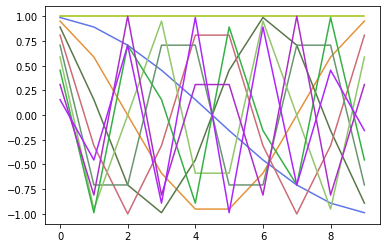

In [4]:
#This cell we're just examining the cos term in the equation to calculate DCT-II coefficients
N = 10
#this is essentially sampling N points from N cos waves ranging from cos(0) -> cos((N-1)x)
cos_waves = [[math.cos((pt + 0.5) * math.pi * k / N) for pt in range(N)] for k in range(N)]

for cos, col in zip(cos_waves, generate_n_colours(N)):
    plt.plot(cos, col)

#the waves are supposed to be orthogonal to each other, so we can check that as well 
ortho = np.zeros((N, N))
for a in range(N):
    for b in range(N):
        if a != b:
            ortho[a,b] = np.dot(cos_waves[a], cos_waves[b])

print(np.max(ortho))
#values are realllyyy close to zero, so given rounding errors we can see that that is true 


#### Chroma Subsampling:

If the input image is an RGB image, we first convert the colour space to YCbCr. Y (Luma) is essentially the brightness component, and Cb and Cr are the Chroma red and Chroma blue channels. Because human vision is less sensitive to changes in colour, we can more aggressively compress the colour channels to achieve compression without affecting quality too much. In JPEG this is done via downsampling of the colour channels. There are different ratios of downsampling (e.g. either only in the horizontal direction or in the vertical direction, or for example taking the maxima vs the average of a group of pixels). For our implementation, we will take the average of a group of pixels during downsampling! -- (for this we can convolve with some kernel with values 1 for nxn kernel!)

#### Intuition of DCT: 
Essentially, dct is a signal transformation method. let's take a row of an image. The points formed by the 
values creates a 1d vector. If we plot it out, it will look like some random curve perhaps. The point of 
DCT is that we're trying to represent the vector as the sum of different cos waves. (The theory I suppose
dictates that if you have n points in your vector, n cos waves will be sufficient to recreate it. 

```python
e.g. if you have 8 points, 
a*cos(0) b*(constant) + c*cos(x) + d*cos(2x) + e*cos(3x) ... + h*cos(8x)
```
where a-h are coefficients that
we're trying to find.


So how do we find these coefficients? In a vector of 8 points for example, we can also sample 8 points 
from each cosine wave - perhaps by dividing the interval by n and sampling the mid-points 

We then calculate the dot product between the cosine vector and our vector of interest to see how similiar it is.
(dot product is equal to the summation term in the equation)




#### Quantization:

essentially we divide the coeffs with a table, where top left divisors are smaller, and 
progressively gets larger as we get to bottom right. After forcing the values to be ints, a lot of the 
higher frequency components (closer to lower right) will zero out (they are start out with smaller 
values typically.) So the act of doing that is quantization!



    

#### Run-Length Encoding (RLE):

The main point of RLE in jpeg compression is that we expect a lot of zeros in the quantized coefficients. (especially as we approach the bottom right corner of the array, where the high freq components are.) To create many consecutive zeros, we vectorise the array using a zig zag scan. Run length encoding (essentially replacing chain of N zeros with a something like 0[xN])), we can compress the representation of the coefficients. 

we won't follow the convention of jpeg here, just normal rle
```python
jpeg style encoding:
[(r,s), c]
r - number of 0's preceding value 
s - number of bits needed to encode value c 
c - coefficient value 
(0,0) used to indicate the end of a block
```

Also, jpeg compression encodes rle progressively: ie. the first rle encodes Bi(0,0) for i blocks. vs Sequential coding meaning rle for each block separately (what we're doing here.) Progressive encoding is slightly better in practice I think!


#### Huffman Encoding: 

https://www.youtube.com/watch?v=B3y0RsVCyrw <- Reducible video! super good


The basic idea is that we want to encode very frequent symbols (ie. pixel values / run-length encodings) with smaller bits,
and infrequent symbols with larger bits to achieve compression. (The lower bound for how much we can compress a certain categorical distribution
is the entropy of the distribution (proof here: https://mbernste.github.io/posts/sourcecoding/ but I need to learn about langragian multipliers
to understand the solution to the optimization problem))


The basic idea is that we build a binary tree, where if a right child represents adding a 1 to the code word, and left child adds a 0 to the code word.
How do we build this tree? We basically examine the frequency of each symbol within our current distribution. We take the most infrequent pair (ordered
using a min priority queue), and group them together to form a node. This internal node is then reinserted into the priority queue, and the process
is repeated until the queue has 2 nodes left, at which point we put the final two nodes under the root node. 



In [5]:
class ChromaSubsampler:
    def __init__(self, kernel=np.ones((2,2))):
        #kernel is used in downsampling - the size of the kernel determines the stride as well ie. how much we 
        #reduce each dimension by. if you want another sampling scheme e.g. picking top right pixel of every
        #2x2 roi, then you can just use specific values within the kernel!
        self.kernel = kernel
        if len(self.kernel.shape) == 1:
            #if only 1-d kernel provided we'll assume it's for horizontal direction
            self.kernel = np.expand_dims(self.kernel, axis=0)
        elif len(self.kernel.shape) > 2:
            raise Exception('Kernel has too many dimensions!')
            
        self.h_stride, self.w_stride = self.kernel.shape 

    def rgb_to_ycbcr(self, img, delta=128):
        #follows the transform from opencv - delta depends on the dtype of the image 
        #by default delta=128 for 8-bit images  
        img = img.astype(np.float32)  #need to force image to float first before calculation!!!!! (important)
        r = img[:, :, 0]
        g = img[:, :, 1]
        b = img[:, :, 2]
        Y = (0.299 * r) + (0.587 * g) + (0.114 * b) 
        Cr = (r - Y) * 0.713 + delta 
        Cb = (b - Y) * 0.564 + delta 
        return np.stack([Y, Cb, Cr], axis=-1).astype(np.uint8)

    def ycbcr_to_rgb(self, img, delta=128):
        img = img.astype(np.float32)
        Y = img[:, :, 0]
        Cb = img[:, :, 1]
        Cr = img[:, :, 2]
        r = Y + 1.403 * (Cr - delta)
        g = Y - 0.714 * (Cr - delta) - 0.344 * (Cb - delta)
        b = Y + 1.773 * (Cb - delta)
        return np.stack([r, g, b], axis=-1).astype(np.uint8)

    def downsample(self, img):
        h,w = img.shape
        self.h_stride, self.w_stride
        output = np.empty((h//self.h_stride, w//self.w_stride))
        kernel = self.kernel / np.sum(self.kernel) #normalize values so we are taking the average!

        #trim values if kernel doesnt divide array perfectly
        h_trimmed = h - h % self.h_stride
        w_trimmed = w - w % self.w_stride

        for i in range(0, h_trimmed, self.h_stride):
            for j in range(0, w_trimmed, self.w_stride):
                output[i//self.h_stride, j//self.w_stride] = int(np.sum(img[i:i+self.h_stride, j:j+self.w_stride] * kernel))
    
        return output
        
    def subsample(self, rgb):
        ycbcr = self.rgb_to_ycbcr(rgb)
        subsampled = [ycbcr[:, :, 0]] + [self.downsample(img) for img in [ycbcr[:, :, i] for i in range(1, 3)]]
        return subsampled

    def upsample(self, subsampled):
        #returns a ycbcr image from downsampled 
        h, w = subsampled[0].shape 
        cb = np.zeros((h,w))
        cr = np.zeros((h,w))

        h_trimmed = h - h % self.h_stride
        w_trimmed = w - w % self.w_stride
        i_sub_max = (h_trimmed - self.h_stride) // self.h_stride
        j_sub_max = (w_trimmed - self.w_stride) // self.w_stride
        for i in range(h):
            for j in range(w):
                i_sub = min(i//self.h_stride, i_sub_max)
                j_sub = min(j//self.w_stride, j_sub_max)
                cb[i, j] = subsampled[1][i_sub, j_sub]
                cr[i, j] = subsampled[2][i_sub, j_sub]
        return np.stack([subsampled[0], cb, cr], axis=-1).astype(np.uint8)

    

In [6]:
class DCT:
    def __init__(self):
        self.cos_waves = {}
        self.inv_cos_waves = {}

    @staticmethod
    def generate_cos_matrix(n):
        return np.array([[math.cos((pt + 0.5) * math.pi * k / n) for pt in range(n)] for k in range(n)])

    def get_cos_waves(self, n):
        if n not in self.cos_waves:
            self.cos_waves[n] = self.generate_cos_matrix(n)
        return self.cos_waves[n] 

    def get_inv_cos_waves(self, n):
        if n not in self.inv_cos_waves:
            self.inv_cos_waves[n] = np.linalg.inv(self.get_cos_waves(n))
        return self.inv_cos_waves[n]

    def dct_1d(self, vec):
        #first we want the length of the vector - we won't restrict the length of the vector here 
        n = len(vec)
        # for n waves, we have to sample n points - in dct II, we essentially
        # divide the interval (180 / math.pi) into N segments, and sample the midpoint (hence the + 0.5)
        # res = np.array([np.dot(vec, cos) for cos in cos_waves])
        res = np.matmul(self.get_cos_waves(n), vec) #same as the list comp!
        #the fact that dct can be represented as a matrix multiplication signals that it's a linear transformation
        return res 

    def dct_2d(self, arr, offset=128, scalar=2):
        #dct1d horizontally first, then vertically
        arr = arr - offset
        res = np.stack([self.dct_1d(arr[row, :]) for row in range(arr.shape[0])], axis=0) * scalar
        res = np.stack([self.dct_1d(res[:, col]) for col in range(arr.shape[1])], axis=1) * scalar
        return res

    def inverse_dct_1d(self, coeffs):
        cos_waves = self.get_inv_cos_waves(len(coeffs))
        #by inverting the cos waves matrix, we are turning each COLUMN into cos waves vs each row 
        #then, when we do matmul, we are summing at each point the coeff * cos wave for point x, to get the original 
        #points ie. wave back
        return np.matmul(cos_waves, coeffs)

    def inverse_dct_2d(self, arr, offset=128, scalar=2):
        res = np.stack([self.inverse_dct_1d(arr[:, col]) for col in range(arr.shape[1])], axis=1) / scalar
        res = np.stack([self.inverse_dct_1d(res[row, :]) for row in range(arr.shape[0])], axis=0) / scalar
        res = res + offset
        return res.astype(np.uint8)
        

In [7]:
class Quantizer:
    luminance_table = np.array([
    [16, 11 ,10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
    ], dtype=np.float32)

    chrominance_table = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
    ], dtype=np.float32)

    def __init__(self, 
                luminance_factor=1, 
                chrominance_factor=1,
                min_val=1, 
                max_val=9999):
                
        self.luminance_factor = luminance_factor 
        self.chrominance_factor = chrominance_factor
        self.l_table = self.luminance_table * self.luminance_factor
        self.c_table = self.chrominance_table * self.chrominance_factor
        self.min_val = min_val 
        self.max_val = max_val

    @staticmethod
    def resize_quantization_table(table, shape):
        if table.shape != shape:
            table = cv2.resize(table, shape)
        return table 

    def quantize_table(self, shape, luminance=True):
        h, w = shape[0], shape[1]
        q = self.l_table if luminance else self.c_table
        q = self.resize_quantization_table(q, (w,h))
        q = np.clip(q, self.min_val, self.max_val)
        return q 


    def quantization(self, mat, luminance=True):
        #we're going to take the JPEG default 8x8 quantization table, and upscale to our image size
        #https://arxiv.org/pdf/1802.00992.pdf
        #we just use a straightward scalar to change how aggressive the values are - in practice it's probs different?
        q = self.quantize_table(mat.shape, luminance=luminance)
        scaled = mat / q
        return scaled.astype(np.int32)

    def inverse_quantization(self, mat, luminance=True):
        q = self.quantize_table(mat.shape, luminance=luminance)
        inverse = mat * q 
        return inverse.astype(np.int32)
        

In [8]:
class RLE:
    @staticmethod
    def in_bounds(pos, h, w):
        return 0 <= pos[0] < h and 0 <= pos[1] < w

    def zig_zag_encode(self, arr):
        #key thing here is that points on the same diagonal share the same sum, so 
        #we can use that to identify what we should do at odd and even diagonals
        # - zig zag sequence follows the reducible video 
        pos = [0, 0]
        h, w = arr.shape[0], arr.shape[1]
        res = [] 
        while pos != [h-1,w-1]:
            res.append(arr[tuple(pos)])
            if sum(pos) % 2 == 0:
                next_pos = [pos[0]-1, pos[1]+1]
                if self.in_bounds(next_pos, h, w):
                    pos = next_pos 
                else:        
                    # detect edge case where we are at the rightmost of array
                    # if so we shift down                
                    if pos[1] + 1 < w:
                        pos[1] += 1
                    else:
                        pos[0] += 1
            else:
                next_pos = [pos[0]+1, pos[1]-1]
                if self.in_bounds(next_pos, h, w):
                    pos = next_pos 
                else:
                    # detect edge case where we are at the bottom of array
                    # if so we shift right
                    if pos[0] + 1 < h:
                        pos[0] += 1
                    else:
                        pos[1] += 1
        res.append(arr[tuple(pos)])
        return res

    def zig_zag_decode(self, vec, shape):
        #just reversed operations in zig_zag_encode
        h, w = shape[0], shape[1] 
        res = np.zeros(shape)
        pos = [h-1, w-1]
        res[h-1, w-1] = vec[-1]

        for i in range(len(vec)-2, -1, -1):
            if sum(pos) % 2 == 0:
                next_pos = [pos[0]+1, pos[1]-1]
                if self.in_bounds(next_pos, h, w):
                    pos = next_pos 
                else:
                    if pos[1] - 1 > -1:
                        pos[1] -= 1 
                    else:
                        pos[0] -= 1
            else:
                next_pos = [pos[0]-1, pos[1]+1]
                if self.in_bounds(next_pos, h, w):
                    pos = next_pos 
                else:
                    if pos[0] - 1 > -1:
                        pos[0] -= 1
                    else:
                        pos[1] -= 1
            res[tuple(pos)] = vec[i]
        return res

    def encode(self, vec):
        zig_zag = self.zig_zag_encode(vec)
        zero_count = 0
        res = []
        for val in zig_zag:
            if val == 0:
                zero_count += 1 
            else:
                if zero_count > 0:
                    zeros = f'0[x{zero_count}]' if zero_count > 1 else 0
                    res.append(zeros)
                zero_count = 0
                res.append(val)
        if zero_count > 0:
            zeros = f'0[x{zero_count}]' if zero_count > 1 else 0
            res.append(zeros)
        return res

    def decode(self, rle, shape):
        vec = [] 
        for val in rle:
            if type(val) == str:
                for _ in range(int(val[3:-1])):
                    vec.append(0)
            else:
                vec.append(val)

        res = self.zig_zag_decode(vec, shape)

        return res 

    

In [9]:
class HuffmanNode:
    def __init__(self, sym=None, freq=None, left_child=None, right_child=None):
        self.sym = sym
        self.freq = freq 
        self.left_child = left_child
        self.right_child = right_child

    def __lt__(self, other_node):
        return self.freq < other_node.freq 

    def __gt__(self, other_node):
        return self.freq > other_node.freq


class HuffmanTree:
    def __init__(self):
        self.root = None 
        self.codes = {}

    def encode(self, vec):
        assert self.root is not None 
        return ''.join([self.get_code_word(sym) for sym in vec])

    def get_code_word(self, sym):
        return self.codes[sym]

    def decode(self, code):
        assert self.root is not N
        vec = []
        curr = self.root 
        for val in code:
            if int(val):
                curr = curr.right_child 
            else:
                curr = curr.left_child 
            
            if curr.sym is not None:
                vec.append(curr.sym)
                curr = self.root 
        return vec

    def generate_codes(self):
        self.traverse(self.root, '')

    def traverse(self, node, curr_code):
        if node:
            if node.sym is not None:
                self.codes[node.sym] = curr_code 
            self.traverse(node.left_child, curr_code + '0')
            self.traverse(node.right_child, curr_code + '1')

    def generate_root(self, vec):
        freqs = defaultdict(lambda: 0)
        for sym in vec:
            freqs[sym] += 1 

        pq = PriorityQueue()
        #check if this is valid?
        pq.heapify([(freq, HuffmanNode(sym=sym, freq=freq)) for sym,freq in freqs.items()])

        while len(pq) > 1:
            _, node_1 = pq.delete()
            _, node_2 = pq.delete()
            #ordering of left or right does not matter in the construction
            #of huffman tree, unlike in shannon-fano tree, because
            #we're always combining the smallest possible 2 nodes anyway
            new_node = HuffmanNode(freq=node_1.freq+node_2.freq, left_child=node_1, right_child=node_2)
            pq.insert((new_node.freq, new_node))

        self.root = pq.delete()[1]
        self.generate_codes()




In [10]:
class ImageSlicer:
    """slicer will split images into block_size. if at edges row/column cannot be 
    evenly divided, we will take a bit of the previous block to fill the block_size
    the main reason for this is if block size is known, then it's easier to decode
    during rle. This obviously sacrifices some efficiency, because some blocks 
    will overlap. Not sure how JPEG decodes RLE for not nicely divisible dimensions 
    because most slides/articles talk about 8x8 blocks, but not edge cases."""
    def __init__(self, block_size):
        self.blocks = []
        self.h_int, self.w_int = block_size

    @staticmethod
    def generate_range(i, max_i, i_int):
        i_end = i + i_int if i + i_int < max_i else (max_i-1)
        i_start = max(0, i if i_end != (max_i-1) else (max_i - 1 - i_int))
        return i_start, i_end


    def slice_image(self, img):
        h, w = img.shape[0], img.shape[1]
        for i in range(0, h, self.h_int):
            for j in range(0, w, self.w_int):
                i_start, i_end = self.generate_range(i, h, self.h_int)
                j_start, j_end = self.generate_range(j, w, self.w_int)
                self.blocks.append(img[i_start:i_end, j_start:j_end])
        return self.blocks
    
    def compose_from_blocks(self, blocks, shape, greyscale=False):
        h, w = shape 
        output = np.zeros((h, w) if greyscale else (h, w, 3))
        blocks_gen = iter(blocks)
        for i in range(0, h, self.h_int):
            for j in range(0, w, self.w_int):
                i_start, i_end = self.generate_range(i, h, self.h_int)
                j_start, j_end = self.generate_range(j, w, self.w_int)
                output[i_start:i_end, j_start:j_end] = next(blocks_gen)
        return output.astype(np.uint8)

In [11]:
class JPEGLike:
    def __init__(self, 
                fpath,
                luminance_factor=1,
                chrominance_factor=1,
                kernel=np.ones((2,2)),
                block_size=(8,8),
                min_val=1,
                max_val=999,
                greyscale=False
                ):
        """
            Parameters
            ----------
            fpath : str
                filepath of image to be compressed 
            luminance_factor: [int, float]
                scalar for luminance quantization table. Higher leads to greater quantization
            chrominance_factor: [int, float]
                scalar for luminance quantization table. Higher leads to greater quantization
            kernel: np.array
                kernel used in downsampling chroma channels 
            block_size: tuple
                block sizes to separate input image into 
            min_val: [int, float] >= 1
                min val of quantization table after scaling 
            max_val: [int, float] 
                max val of quantization table after scaling
            grayscale: bool
                whether to read the image as a grayscale image or not
        """
        self.fpath = fpath 
        self.greyscale = greyscale 
        init_color = cv2.COLOR_BGR2GRAY if self.greyscale else cv2.COLOR_BGR2RGB
        self.img = cv2.cvtColor(cv2.imread(self.fpath), init_color)

        self.h, self.w = self.img.shape[0], self.img.shape[1]
        self.luminance_factor = luminance_factor 
        self.chrominance_factor = chrominance_factor 
        self.kernel = kernel
        self.block_size = block_size
        #min max vals of quantization table after scaling - 
        self.min_val = min_val 
        assert min_val >= 1
        self.max_val = max_val 

        self.slicer = ImageSlicer(self.block_size)
        self.subsampler = ChromaSubsampler(kernel=self.kernel)
        self.dct = DCT()
        self.quantizer = Quantizer(luminance_factor=self.luminance_factor,
                                    chrominance_factor=self.chrominance_factor,
                                    min_val=self.min_val,
                                    max_val=self.max_val)
        self.rle = RLE()
        self.huffman_tree = HuffmanTree()
        self.huffman_codes = None

    @staticmethod
    def flatten(lst, n=1):
        for _ in range(n):
            lst = list(itertools.chain.from_iterable(lst))
        return lst

    def compress(self):
        blocks = self.slicer.slice_image(self.img)
        rles = []
        for block in tqdm(blocks):
            if not self.greyscale:
                subsampled = self.subsampler.subsample(block)
            coefficients = [self.dct.dct_2d(block)] if self.greyscale else [self.dct.dct_2d(img) for img in subsampled]
            quantized = [self.quantizer.quantization(coeff, luminance=lum) for coeff, lum in zip(coefficients, [1,0,0])]
            rles.append([self.rle.encode(q) for q in quantized])

        self.huffman_tree.generate_root(self.flatten(rles, n=2))
        self.huffman_codes = [[self.huffman_tree.encode(v) for v in r] for r in rles]


    def decompress(self, huffman_codes):
        blocks = []
        h_stride, w_stride = self.kernel.shape
        subsampled_block_size = (self.block_size[0]//h_stride, self.block_size[1]//w_stride)
        for bit_codes in tqdm(huffman_codes):
            rles = [self.huffman_tree.decode(bits) for bits in bit_codes]
            #rmb block sizes here are different for different channels!
            quantized = [self.rle.decode(r, bs) for r, bs in zip(rles, [self.block_size] + [subsampled_block_size]*2)]
            coefficients = [self.quantizer.inverse_quantization(q, luminance=lum) for q, lum in zip(quantized, [1,0,0])]
            subsampled = [self.dct.inverse_dct_2d(coeff) for coeff in coefficients]
            if not self.greyscale:
                blocks.append(self.subsampler.upsample(subsampled))
            else:
                blocks.append(subsampled[0])
        
        img = self.slicer.compose_from_blocks(blocks, (self.h, self.w), greyscale=self.greyscale)
        if not self.greyscale:
            img = self.subsampler.ycbcr_to_rgb(img)
        return img
        
            

100%|██████████| 16952/16952 [00:16<00:00, 1051.44it/s]


Text(0.5, 1.0, 'original')

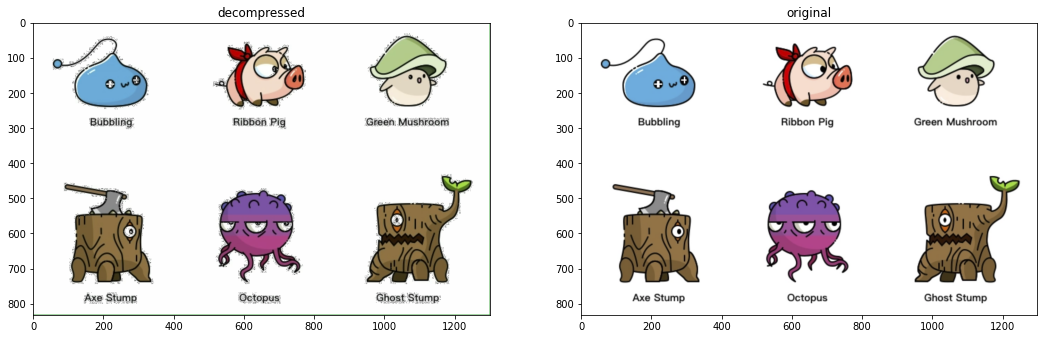

In [12]:
test_1 = JPEGLike('test.png', 
                luminance_factor=1, 
                chrominance_factor=1, 
                kernel=np.ones((2,2)),
                block_size=(8,8), 
                greyscale=False)
test_1.compress()
decompressed = test_1.decompress(test_1.huffman_codes)

fig, axes = plt.subplots(1,2, figsize=[18,18])
axes[0].imshow(decompressed)
axes[0].set_title('decompressed')
axes[1].imshow(test_1.img)
axes[1].set_title('original')


100%|██████████| 62500/62500 [01:06<00:00, 938.70it/s] 


Text(0.5, 1.0, 'original')

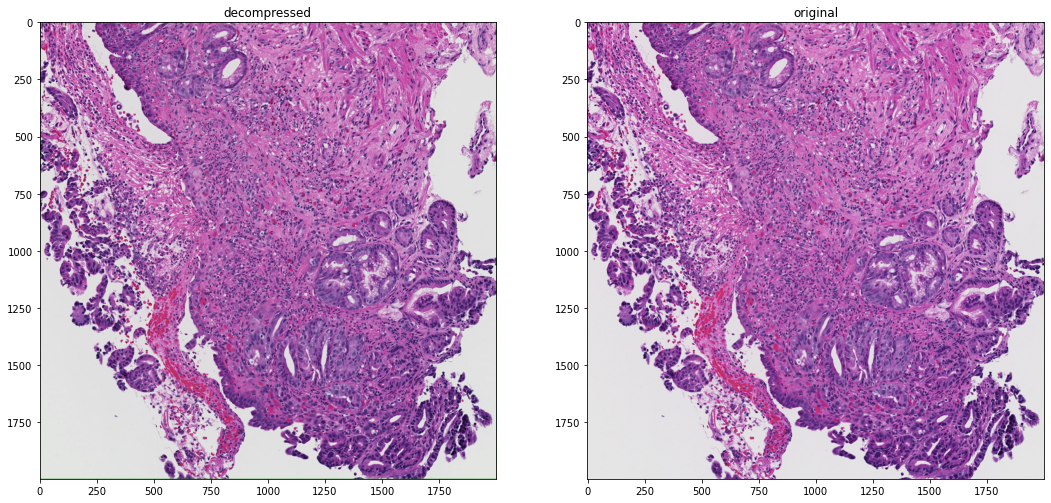

In [13]:
test_2 = JPEGLike('test_2.jpg', 
                luminance_factor=1, 
                chrominance_factor=1, 
                kernel=np.ones((2,2)),
                block_size=(8,8), 
                greyscale=False)
test_2.compress()
decompressed_2 = test_2.decompress(test_2.huffman_codes)

fig, axes = plt.subplots(1,2, figsize=[18,18])
axes[0].imshow(decompressed_2)
axes[0].set_title('decompressed')
axes[1].imshow(test_2.img)
axes[1].set_title('original')


100%|██████████| 11664/11664 [00:11<00:00, 995.01it/s] 


Text(0.5, 1.0, 'original')

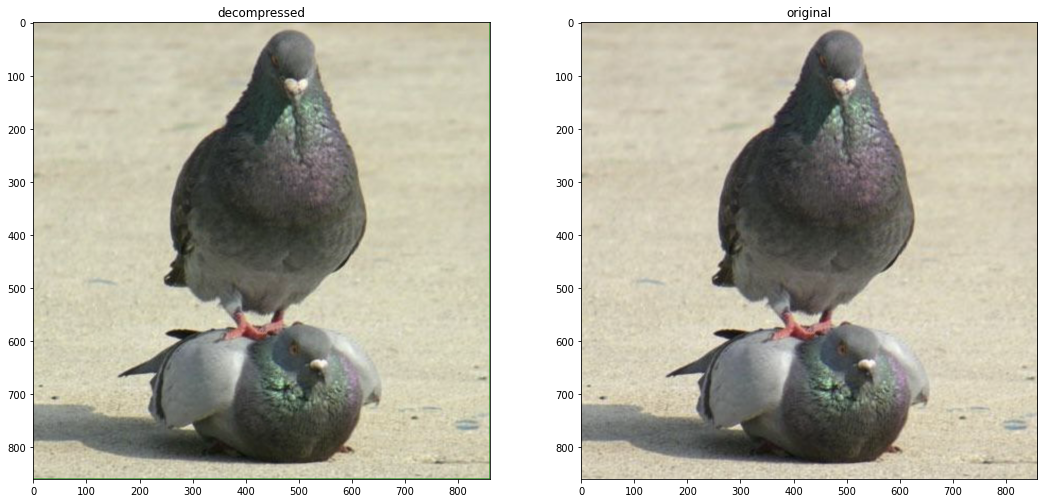

In [14]:
test_3 = JPEGLike('test_3.png', 
                luminance_factor=1, 
                chrominance_factor=1, 
                kernel=np.ones((2,2)),
                block_size=(8,8), 
                greyscale=False)
test_3.compress()
decompressed_3 = test_3.decompress(test_3.huffman_codes)

fig, axes = plt.subplots(1,2, figsize=[18,18])
axes[0].imshow(decompressed_3)
axes[0].set_title('decompressed')
axes[1].imshow(test_3.img)
axes[1].set_title('original')

100%|██████████| 13400/13400 [00:05<00:00, 2304.19it/s]


Text(0.5, 1.0, 'original')

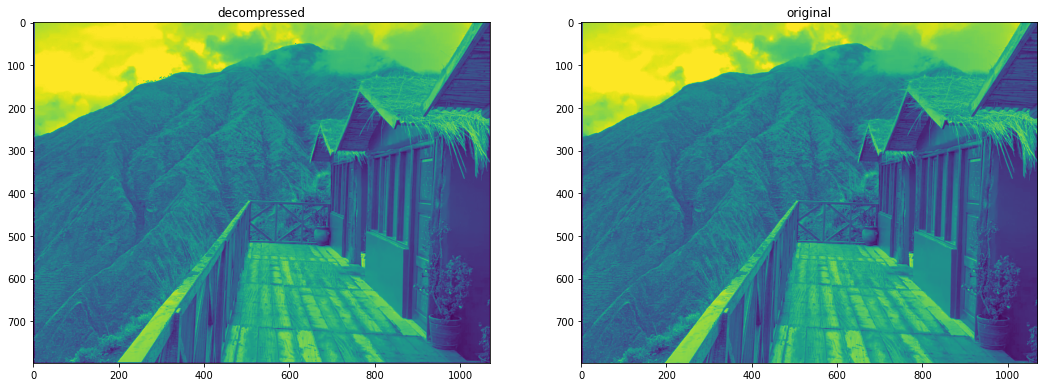

In [15]:
test_4 = JPEGLike('test_4.png', 
                luminance_factor=1, 
                chrominance_factor=1, 
                kernel=np.ones((2,2)),
                block_size=(8,8), 
                greyscale=True)
test_4.compress()
decompressed_4 = test_4.decompress(test_4.huffman_codes)

fig, axes = plt.subplots(1,2, figsize=[18,18])
axes[0].imshow(decompressed_4)
axes[0].set_title('decompressed')
axes[1].imshow(test_4.img)
axes[1].set_title('original')

Seems like it works! The compression can't be compared to actual JPEG obviously, but it was nice to see the process. The implementation is such that you can tweak all the parameters, e.g. see how luminance and chrominance factors affect the quality of the compression, try different kernels, block_sizes, etc. Interestingly when block_size is the standard (8,8), the current tables seem to be too harsh and quality and colour erodes quickly> I may have missed some scaling in my implementation of the coefficients? Increasing block_size and reducing luminance and chrominance factors seems to preserve the low freq components nicely? Also, tried adding 2x scaling like scipy implementation, also seems to help a bit. But looks like it depends on the image... The performance of the implementation is a little bit slow, haven't optimized it too much or refactored it a ton so there should be room for improvement! Actually this implementation should be quite good for cythonising, because a lot of the array sizes are known at initialization, and there are lots of for loops doing array indexing and assignment!

### QOI (Quite Okay Image Format)

Watched another reducible video and saw this interesting lossless compression called QOI. (https://www.youtube.com/watch?v=EFUYNoFRHQI&ab_channel=Reducible). The premise is that PNG is widely used, but the algorithm is really complicated, and is generally computationally expensive. 
QOI is a faster encoding scheme that can offer comparable compression in some images, and it's much simpler. So just wanted to try to implement a version of it! 

spec: https://qoiformat.org/qoi-specification.pdf

In [161]:
#We'll only work with rgb images, encoding and decoding!
#I'll only save the bit strings. Won't actually write the bytes to a file.
class Pixel:
    def __init__(self, r, g, b):
        self.r = r 
        self.g = g 
        self.b = b 

    @property
    def hash(self):
        #interesting how this simple hash function doesn't result in collision...
        a = 255 #a is always 1 here because opacity is 1 in regular rgb
        return ((self.r * 3) + (self.g * 5) + (self.b * 7) + (a * 11)) % 64

    @property
    def pixel_values(self):
        return (self.r, self.g, self.b)

    def set_pixel_values(self, values):
        assert len(values) == 3
        self.r = values[0]
        self.g = values[1]
        self.b = values[2]

    def __eq__(self, other):
        return (self.r == other.r and self.g == other.g and self.b == other.b)

    def __getitem__(self, item):
        return self.pixel_values[item]


class QOI:
    tags = [192, 0, 64, 128, 254]
    data_mask = 0x3f #hex(63)
    tag_mask = 0xc0 #hex(19)      

    def encode(self, img):
        h,w,c = img.shape
        assert c == 3 
        desc = [bin(dim) for dim in img.shape[:2]] #img description
        seen = [Pixel(0,0,0) for _ in range(64)]
        encoding = [] #list of ints to be converted to bit strings
        curr = Pixel(0, 0, 0)
        prev = Pixel(0, 0, 0)
        run_length = 0

        for i in range(h):
            for j in range(w):
                curr.set_pixel_values(img[i, j])
                #case 1: run of previous pixel 
                if curr == prev:
                    run_length += 1 
                    #run length max 62 b/c 63 is reserved as a tag value
                    #also need to stop if final pixel is part of a run
                    if run_length == 62 or (i*j) == (h-1)*(w-1):
                        #max of run length - save a byte 
                        #We have to do run_length -1 b/c 
                        #self.tags[0] | 62 is equal to the RGB 8 bit tag. So it'll mess everything up
                        encoding.append(self.tags[0] | run_length-1)
                        run_length = 0
                else:
                    #we meet a different pixel - save previous run 
                    if run_length > 0:
                        encoding.append(self.tags[0] | run_length-1)
                        run_length = 0
                    
                    #case 2: see if we've seen it in the last 64 
                    if seen[curr.hash] == curr:
                        encoding.append(self.tags[1] | curr.hash)
                    else:
                        #case 3: calculate pixel differences
                        dr, dg, db = [int(prev[i]) - int(curr[i]) for i in range(3)]
                        if all([-2 <= d <= 1 for d in [dr, dg, db]]):
                            encoding.append(self.tags[2] | ((dr + 2) << 4 | (dg + 2) << 2 | (db + 2)))
                        elif all([-32 <= dg <= 31, -8 <= dr - dg <= 7, -8 <= db-dg <= 7]):
                            encoding.append(self.tags[3] | (dg + 32))
                            encoding.append((dr-dg+8) << 4 | (db-dg+8))
                        else:
                            #case 4: save as stream of full bytes
                            encoding.append(self.tags[-1])
                            encoding = encoding + [col for col in curr.pixel_values]

                #update seen - running array is updated by newest pixel that hashes to some location
                seen[curr.hash].set_pixel_values(curr.pixel_values)
                prev.set_pixel_values(curr.pixel_values)

        if run_length > 0:
            #final byte if run length isnt 0
            encoding.append(self.tags[0] | run_length)

        return desc + ['{0:08b}'.format(val) for val in encoding]

    def decode(self, encoding):
        h,w = [int(e, 2) for e in encoding[:2]]
        bits_gen = iter(encoding[2:])
        pixels = []
        seen = [Pixel(0,0,0) for _ in range(64)]
        curr = Pixel(0, 0, 0)
        prev = Pixel(0, 0, 0)

        while True:
            try:
                curr_bits = next(bits_gen)
            except StopIteration:
                break 

            curr_int = int(curr_bits, 2)
            if curr_int == self.tags[-1]:
                #rgb bytes stream
                rgb_bytes = [next(bits_gen) for _ in range(3)]
                curr.set_pixel_values([int(b, 2) for b in rgb_bytes])
                pixels.append(curr.pixel_values)
            else:
                tag = curr_int & self.tag_mask
                data = curr_int & self.data_mask
                if tag == self.tags[3]:
                    #Diff 2 LUMA
                    dg = data - 32
                    next_int = int(next(bits_gen), 2)
                    dr_dg =  next_int >> 4 
                    dr = dr_dg + dg - 8
                    db_dg = next_int & 0xf #hex(15)
                    db = db_dg + dg - 8
                    curr.set_pixel_values([prev[i] - diff for i,diff in enumerate([dr, dg, db])])
                    pixels.append(curr.pixel_values)
                elif tag == self.tags[2]:
                    #Diff 1 
                    dr = ((data >> 4) & 0x03) - 2
                    dg = ((data >> 2) & 0x03) - 2
                    db = (data & 0x03) - 2
                    curr.set_pixel_values([prev[i] - diff for i,diff in enumerate([dr, dg, db])])
                    pixels.append(curr.pixel_values)
                elif tag == self.tags[1]:
                    #INDEX
                    curr.set_pixel_values(seen[data].pixel_values)
                    pixels.append(curr.pixel_values)
                elif tag == self.tags[0]:
                    #RUN
                    curr.set_pixel_values(prev.pixel_values)
                    #data+1 b/c run_length is stored with -1 bias
                    for _ in range(data+1):
                        pixels.append(curr.pixel_values)
                else:
                    raise Exception(f'tag {tag} not found.')
  
            seen[curr.hash].set_pixel_values(curr.pixel_values)
            prev.set_pixel_values(curr.pixel_values)

        out = np.reshape(np.array(pixels), (h, w, 3))
        return out

        


In [169]:
qoi = QOI()
n_per_folder = 10
max_size = 256
img_dirs = glob.glob(os.path.expanduser('~') + '/Documents/qoi_images/*')

pbar = tqdm(total=len(img_dirs) * n_per_folder)
for folder in img_dirs:
    fpaths = glob.glob(folder + '/*')
    imgs = [cv2.imread(fpath) for fpath in fpaths]
    img_sizes = [np.sum(img.shape) for img in imgs if img is not None]
    imgs = [img for _, img in sorted(zip(img_sizes, imgs), key=lambda zipped:zipped[0])]

    for img in imgs[:n_per_folder]:
        if img is not None:
            if np.sum(img.shape[:2]) <= (2*max_size):
                encoding = qoi.encode(img)
                decoded = qoi.decode(encoding)
                assert np.array_equal(img, decoded)
            pbar.update(1)
pbar.close()


 15%|█▌        | 20/130 [01:12<00:42,  2.60it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: CRC error
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 32%|███▏      | 41/130 [01:42<00:39,  2.24it/s]libpng warning: iCCP: known incorrect sRGB profile
libpn

QOI implementation seems to work! It issss quite slow, but I guess that's the nature of lossless encoding... plus again this implementation should be fairly suitable for cythonising, because it's a lot of bit manipulation and simple operations, which should be quite nice to statically type!uuuu

### Notes on Modular Exponentiation

Haven't dug deep into the maths (brain is tired), but let's start by thinking about the iterative algorithm for solving 
a^e mod b.
So we want to find the modulus of some exponentiated number. calculated a^e could be very expensive, so we can do it step by step.
let's start off with:
```python
res = 1, e' = 0
```
With modulus think of a clock... so what we're really trying to find, is for a clock sized b, what is the remainder after we 
wrap around the block (a^e / b) times? Essentially, we don't care how many times a^e wraps around the clock right? So:
```python
for e in range(e_prime): <- number of times we are walking around the clock by distance a (exponent)
    res = (res * a) % b <- remainder after walking around the clock by distance a
return res 
```

But iterative isn't really fast when e is large... faster way is the recursive method (which is the same as sum and multiply algorithm 
https://www.youtube.com/watch?v=cbGB__V8MNk&ab_channel=Computerphile)

Basically, incrementing exponent by one is slow. A faster way is to square our number so we can reach e faster. 
The below function is an interative form of the recursive algorithm:


```python
def binpow(a, e):
    res = 1 #base case b/c when e == 0, a^e = 1. 
    e_prime = e #we are starting off from e, and reducing it to 0 until there are no operations left
    while e_prime > 0:
        if e_prime % 2 == 0:
            a = a**2 #equivalent to t -> used to represent a^(e) terms 
            e_prime = e_prime // 2 # # b/c we squared, we can cut e_prime by half 
                                   # equivalent to right shift 1 to drop off the bit we just evaluated
        else:
            res = (res * a) #  -1 on exponent - equivalent to turning off bit after we added to our result
            e_prime -= 1
    return res
```

INTUITION of fast modular exponentiation:
Okay. first of all. ignore the base for now (a). Imagine the exponent in it's binary form 
e.g. if e = 45 (target exponent), bin(45) = 101101, a = 3.
At the beginning of the algorithm, res = 1, meaning res is at the least significant bit.
a = a (a^1), representing a^e at this bit if it's turned on.
The whole idea, again, of binary exponentiation is that, we can represent 
e.g. a^19 as a^16 * a^2 * a^1 ie. the number of we want as the product of our base to exponents of
powers of 2!!!
SO, all we're doing, is finding what exponent in the
power of 2s we need, and multiplying our result against term.
(read that again if you don't understand)
ie. we need to multiply a^16  * a^2 and a^1 TOGETHER to find a^19

so.
as we move along the algorithm (counting bits from the right).
At bit 1 :
e_prime % 2 == 0. This means the last bit is one, and we need that in our result.
SO, what does that mean? it means we need a^e0, and we need to multiply result by a.
that's why res = res * (a = a^1).
e_prime -= 1 effectively turns off that bit.
When this bit is turned off, this bit is revisited, and a squares itself, to advance to 
1 bit forward. (So now a = a^2)

At bit 1:
e_prime % 2 == 0. This means that we don't need the a^(e) term here. we square(a)
so that it's at the next bit's value (a = a^4). At the same time, we divide e_prime by
2 (basically a right shift by 1), and evaluate the next least significant bit.

At bit 3:
e_prime is odd. meaning we need this bit. 
res = res * (a = a^4), then bit is turned off.
Then a = a^8, and we right shift by 1.

At bit 4:
e_prime is odd. meaning we need this bit.
res = res * (a = a^8), then bit is turned off.
Then a = a^16, and we right shift by 1.

At bit 5:
e_prime is even. So a = a^32, and we right shift by 1 

At bit 6:
e_prime is odd. meaning we need this bit.
res = res * (a = a^32). This bit is turned off.
Then a = a^32. and we right shift by 1.


To make this adapt to modulo, we just stick modulus b at the end of each 
multiplication operation, and then think back to the clock analogy.
-- END -- 


```python
def modexp(a, e, b):
    res = 1 #base case b/c when e == 0, a^e = 1. 
    e_prime = e
    while e_prime > 0:
        if e_prime % 2 == 0:
            a = a**2 % b
            e_prime = e_prime // 2 
        else:
            res = (res * a) % b
            e_prime -= 1
    return res
```

nice blogs about fast exponentiation:

https://dev-notes.eu/2019/12/Fast-Modular-Exponentiation/#:~:text=Modular%20exponentiation%20is%20used%20in%20public%20key%20cryptography.&text=You%20could%20brute%2Dforce%20this,to%20have%20any%20practical%20application.

https://japlslounge.com/posts/articles/Fast_Modular_Exponentiation/1.htm



#### Notes on Euclidean Algorithm

https://www.youtube.com/watch?v=Jwf6ncRmhPg&list=PLrm9Y---qlNxXccpwYQfllCrHRJWwMky-&index=2&ab_channel=ProofofConcept <- nice series of videos
Why does euclidean algorithm work?
Let's look at an example: gcd(21, 54)
so the principle is always subtracting the small from the large, until either a or b becomes 0.

Start by thinking about the numbers as prime factors:
21 = 3 * 7 
54 = 3^3 * 2 

So before we start, we can see that 3 is gcd between the two. Let's follow what happens to the factors, as we subtract
(here we're allowed to combine factors to make the multiplication work in terms of gcd * something - gcd * something):

54 - 21 = (3^3 * 2) - (3 * 7) = (3 * 9 * 2) - (3 * 7) = (3 * 11) = 33 (33, 21)

33 - 21 = (3 * 11) - (3 * 7) = 3 * 4 = 12 (21, 12)

21 - 12 = (3 * 7) - (3 * 4) = 3 * 3 = 9 (12, 9)

12 - 9 = (3 * 4) - (3 * 3) = 3 (9, 3)

9 - 3 = (3 * 3) - 3 = 3 * 2 = 6  (6, 3)

6 - 3 = (3 * 2) - 3 = 3 (3, 3)

3 - 3 = 0 (3, 0)

so we're left with 3 and 0, and gcd(3,0) = 3.
(Or in our example, when we end with 3,3, what we have done is 
turn both n and m into 1, so at this point we can take the answer.)
In a more general sense, the two starting numbers can be thought of like this: 

a = n * gcd = 18 * 3 

b = m * gcd = 7 * 3 

where gcd is the largest integer where the above holds true.

a - b = 18 * 3 - 7 * 3 = 11*3 (a - b = (n-m) * gcd -> what we saw happens at each subtraction. -> meaning gcd(a,b) | a-b)

What is recursively substracting max(n,m)-min(n,m) doing?
it kind of takes into account what the video is saying, where 
because we are always subtracting smaller from larger, it's equivalent
to an infinite descent where we'll reach 0 eventually. This then exposes
the gcd.

From the video:

gcd(a,b) = gcd(a, b-a)

it's easier to find a solution to the second problem with smaller numbers.
AND, given the base case is when bi = 0,
because we're always subtracting a smaller integer from the larger,
we will always get another smaller, non negative number, which will tend to 0 
eventually. (number theory)

^ faster division version of this just takes

if b > a:

b = a * q + r 

gcd(a,b) = gcd(a, r) recursively, where r is the remainder (b % a). (basically euclid's algorithms but skips 
some steps.)


https://www.quora.com/Is-there-an-intuitive-explanation-for-Euclids-algorithm-to-find-the-GCD-of-two-numbers
^ from this link 
using our previous identity of 

a = n * gcd 

b = m * gcd 

if a > b, then n > m...

a - b = (n-m) * gcd -> what we saw happens at each subtraction. -> gcd(a,b) | a-b

Because the divisor is preserved from the subtraction, we then just need to repeat until 
(n-m) = 1 to expose the gcd. 

(from a = q * b + r, where r = a mod b)

a mod b = a - q*b (where q*b <= a)

= n * gcd - q * m * gcd (where n > k*m)

= (n-k*m)*gcd

^ (n-k*m) will tend to 1 if n is always > m. k is essentially the number of steps we skip
with the original euclid's algorithm.

#### Multiplicative inverse 

for some number `x` and some number `m`, 
a multiplicative inverse `b (mod m)` of `x` is when `(x * b) mod m = 1`.

A multiplicative inverse only exists, if `x` and `m` are coprimes ie. `GCD(x, m) = 1`.

^ this is our test to see if two numbers have a multiplicative inverse.

Let's say:

`d = gcd(m,x) = am + bx' -> express gcd as some linear combination of m and x 

if a multiplicative inverse exists, it means d = 1.

`1 = am + bx` <- if we apply the mod m to both sides,

`1 (mod m) = (am + bx) (mod m) = bx` <- mod m and am cancels out, because bx is effectively the remainder term (given x is not divisible
                                        by m, which was the prequisite when we set gcd(m,x) = 1).

^so here, b must be the multiplicative inverse we are looking for.

linear diophantine (ie. integer solutions) equation -> ax + by = c, with all terms being integers

^ extended euclidean algorithm will solve ax + by = gcd(a, b)





In [ ]:
def extended_euclidean(x, y):
    #if there was no a and b, it would be equivalent to normal euclidean 
    if y == 0:
        #if y == 0, then b also has to equal 0 
        return (x, 1, 0)
    else:
        (d, a, b) = extended_euclidean(y, x%y) #divison version of euclids theorem
        return 

In [7]:
196 // 180

1